In [1]:
import numpy as np
import pandas as pd
import sys
import os
import re
import csv
import collections as co
import itertools as it
import umap
import hdbscan
import time 
import progressbar
import math
import random
import fileinput

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import scipy.spatial.distance as ssd
import seaborn as sns

from Bio import Align, AlignIO, Phylo
from Bio.Align.Applications import MafftCommandline
from Bio.Seq import Seq 
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix, DistanceCalculator
from ete3 import PhyloTree, Tree, faces, AttrFace, CircleFace, TreeStyle, NodeStyle, TextFace, SequenceFace
from IPython.display import display
from matplotlib import colors 
from scipy.cluster import hierarchy
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from statistics import mean
from scipy import stats
from kneed import DataGenerator, KneeLocator

%matplotlib inline

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)
pd.set_option('display.expand_frame_repr', True)

In [2]:
class frequency(object):
    
    def __init__(self, k = 7, convert = 0):
    
        self.k = k
        self.convert = convert
        self.exist = co.defaultdict(int) 
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.row = 0
        self.matrix = np.empty((self.row, self.col, ),dtype = "float32")
        self.amino = co.defaultdict(str, {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F'
        })
                
    def translate(self, read):
    
        chain = ''

        for i in range(len(read) - 2):
            trip = read[i:i+3]
            chain += self.amino[trip]

        return(chain)
    
    
    def adjust_to_data(self, infile):
    
        self.row = infile.shape[0]
            
        for line, read in infile.itertuples(index=True, name=None):

            if self.convert == 1:
                seq = self.translate(read)
                del read

                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    self.exist[kmer] = 0

            else:
                seq = read
                del read

                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        self.exist[kmer] = 0
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            self.exist[kmer] = 0
            
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.matrix = np.empty((self.row, self.col, ), dtype="float32")
        
        del seq
    
    
    def calculate_frequence(self, infile):
        
        for line, read in infile.itertuples(index=True, name=None): 
                 
            if self.convert == 1:
                seq = self.translate(read)
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    counts[kmer] += 1

            else:
                seq = read
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        counts[kmer] += 1
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            counts[kmer] += 1

            vector = np.array(list(counts.values()), dtype = "float32")

            self.matrix[line] = vector/vector.sum()
            
            counts.clear()
            del vector
            del seq
            del counts
    
    
    def get_keys(self):
        
        return(self.keys)
    
    
    def get_matrix(self):
        
        return(self.matrix)

In [3]:
def subsplit(subtype):
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = ''#np.nan
        N = ''#np.nan
    return(H, N)

In [4]:
def convert_fasta(infile, outfile):

    #with some help from https://stackoverflow.com/questions/50856538/how-to-convert-multiline-fasta-files-to-singleline-fasta-files-without-biopython
    
    with open(infile) as f_input, open(outfile, 'w') as f_output:

        block = []

        for line in f_input:
    
            if line.startswith('>'):

                if block:
                    f_output.write(new_line + ',' + "".join(block) + '\n')
                    block = []
                
                new_line = line.strip().replace('|', ',')
            else:
                block.append(line.strip())
    
        if block:
            f_output.write(new_line + ',' + "".join(block) + '\n')

In [5]:
def get_vectors(sequence, accession, metric, neigh, comp, pca):

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    #Kevins approach
    #freq = frequency(k = 7)
    #freq.calculate_frequence(sequence)
    
    if pca:
        matrix = freq.get_matrix()
        pca_init = PCA(n_components=pca)
        pca_matr = pca_init.fit_transform(matrix)
        #pca_matr = freq.get_matrix()

        dataframe_pca = pd.concat([accession, pd.DataFrame(pca_matr)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        pca_matr = freq.get_matrix()
        dataframe_pca = pd.DataFrame()
    
    #Dimension Reduction with UMAP
    if pca and pca <= comp:
        reduced = pca_matr
    else:
        reduced = umap.UMAP(
            n_neighbors = neigh,
            min_dist = 0.0,
            n_components = comp,
            random_state = 42,
            #metric = 'euclidean',
        ).fit_transform(pca_matr)

    #approximation of cosine by l2 normalization (https://github.com/scikit-learn-contrib/hdbscan/issues/69)
    if metric == 'cosine':
        cos_red = normalize(reduced, norm='l2')
        dataframe = pd.concat([accession, pd.DataFrame(cos_red)], axis=1, copy = False, ignore_index = False).set_index('accession')
    else:
        dataframe = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    return(dataframe, dataframe_pca)

In [6]:
def get_epsilon(dataframe, metric, algo, sample, min_depth = 2, max_iteration = 25):
    
    if metric == 'cosine':
        metric = 'euclidean'
        step = 0.1
    else:
        step = 1.0 
    
    iteration = 0
    dbcv_list = []
    epsilon_list = []
    
    epsilon = 0.0
    depth = 0
    dbcv_best = 0.0 
    #dbcv_last = 0.0
        
    while iteration <= max_iteration or depth <= min_depth:
        
        dbcv_round = dbcv_best
        dbcv_best = 0.0 
        accept = 2
        while accept > 0:

            clusterer = hdbscan.HDBSCAN(
                min_samples = sample,
                min_cluster_size = 2,
                cluster_selection_epsilon = epsilon,
                gen_min_span_tree=True,
                metric = metric,
                algorithm = algo,
            ).fit(dataframe)
            
            dbcv_last = clusterer.relative_validity_.item()
            dbcv_list.append(dbcv_last)
            
            #print('Epsilon: ' + str(epsilon) + '\nRound:   ' + str(dbcv_round)+ '\nBest:    ' + str(dbcv_best) + '\nLast:    ' + str(dbcv_last) +'\n')
            
            epsilon_list.append(epsilon)
            epsilon = round(epsilon + step, int(2+depth))
            
            if dbcv_last <= dbcv_best and dbcv_round <= dbcv_best:
                accept = accept - 1
            else:
                dbcv_best = dbcv_last
                accept = 2

            iteration = iteration + 1
            if iteration >= max_iteration and depth >= min_depth:
                accept = 0
                
        epsilon_best = epsilon_list[dbcv_list.index(dbcv_best)]
        epsilon = round(epsilon_best - (step*0.9), int(2+depth))
        if (epsilon < 0.0):
            epsilon = 0.0

        step = step*0.1
        depth = depth + 1
    
        
    #dbcv_best = max(dbcv_list)
    epsilon_best = epsilon_list[dbcv_list.index(max(dbcv_list))]
    parameter = pd.DataFrame(zip(epsilon_list, dbcv_list), columns = ['epsilon', 'DBCV']).set_index('epsilon')
    
    return(parameter, epsilon_best, max(dbcv_list))

In [7]:
def get_elbow(dataframe, extra, accession, metric, algo, sample, area = (0,500)):
    
    #with some help from https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = 2,
        gen_min_span_tree = True,
        metric = metric,
        algorithm = algo,
    ).fit(dataframe)
    
    label = clusterer_best.labels_
    label_list = label.tolist()
    
    if -1 in label_list:
        label_list.remove(-1)
    
    n_cluster = len(set(label_list))
    
    linkage = clusterer_best.single_linkage_tree_.to_pandas()
    numpy_linkage = linkage.drop(columns=['parent']).to_numpy()
    
    dist = numpy_linkage[:, 2]
    dist_rev = dist[::-1]
    
    if area[1] == -1:
        dist_area = dist_rev[area[0]:n_cluster]
    else:
        dist_area = dist_rev[area[0]:area[1]]
    
    idxs = np.arange(1, len(dist_area) + 1)

    kn = KneeLocator(idxs, dist_area,
        curve='convex',
        direction='decreasing',
        interp_method='polynomial',
        online=True,
        S = 1.0,
    )
    
    n_cluster_raw = kn.knee
    n_cluster_norm = kn.norm_knee
    
    #linkage.set_index('parent', inplace = True)
    elbow = pd.DataFrame({'n_cluster': idxs, 
                          'distance': dist_area, 
                          'x_normalized':kn.x_normalized, 
                          'y_normalized':kn.y_normalized, 
                          'x_difference':kn.x_difference, 
                          'y_difference':kn.y_difference}).set_index('n_cluster')
    epsilon_best = elbow.loc[n_cluster_raw][['distance']].item()
    linkage.set_index('parent', inplace = True)
    
    return(linkage, elbow, epsilon_best, n_cluster_raw, n_cluster_norm)

In [8]:
def get_cluster(epsilon_best, dataframe, extra, accession, metric, algo, sample):
    
    #approximation see above
    if metric == 'cosine':
        metric = 'euclidean'
    
    clusterer_best = hdbscan.HDBSCAN(
        min_samples = sample,
        min_cluster_size = 2,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        metric = metric,
        algorithm = algo,
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    unclustered = label_list.count(-1)
    if -1 in label_list:
        label_list.remove(-1)
    
    n_cluster = len(set(label_list))
    
    cluster = pd.concat([pd.DataFrame(label, columns = ['cluster']), extra, accession], axis=1, copy = False).set_index('accession')
    #linkage = clusterer_best.single_linkage_tree_.to_pandas()
    #linkage.set_index('parent', inplace = True)
    
    N_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['N'].replace('', np.nan).nunique() > 1).cluster.nunique()
    H_unmatch = cluster.query('cluster != -1').groupby('cluster').filter(lambda x: x['H'].replace('', np.nan).nunique() > 1).cluster.nunique() 
    
    cluster.insert(2, 'centroid', False)

    num = cluster['cluster'].max()+1
    values = [True]*num
    accessions = []

    for i in range(num):

        query = cluster.query('cluster == @i')
        match = query.index.values.tolist()
        sub = dataframe.loc[match]

        if not sub.empty:

            tuple_min = (0, '')
            for name, row in sub.iterrows():

                if not tuple_min[1]:
                    dist_min = ssd.cdist([row], sub, metric).mean()
                    tuple_min = (dist_min, name)
                else:
                    dist_min = ssd.cdist([row], sub, metric).mean()
                    if dist_min < tuple_min[0]:
                        tuple_min = (dist_min, name)

            accessions.append(tuple_min[1])

    cluster.update(pd.DataFrame(values, columns=['centroid'], index = accessions))
    
    return(cluster, n_cluster, unclustered, H_unmatch, N_unmatch)

In [9]:
def plot_density(density, segments, outpath, accuracy, suffix = ''):

    for seg in segments:
             
        sns.set_style("dark")
        plt.figure(figsize=(4,4))
        sns.histplot(data = density.query('segment == @seg'), x = "size", kde=False, log_scale=False, element="step", fill = True, bins = round(density.query('segment == @seg')['size'].max()*accuracy))
        plt.xlabel("Count")
        plt.ylabel("#Cluster")
        plt.tight_layout()
        plt.savefig(outpath + 'Cluster_Distribution_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show() 
    

        sns.set_style("dark")
        plt.figure(figsize=(4,4))
        sns.histplot(data = density.query('segment == @seg'), x = "size", kde=False, log_scale=True, element="step", fill = True, bins = round(density.query('segment == @seg')['size'].max()*accuracy))
        plt.xlabel("log(Count)")
        plt.ylabel("#Cluster")
        plt.tight_layout()
        plt.savefig(outpath + 'Cluster_Distribution_Log_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show() 

In [10]:
def plot_normalization(upload, segment, n, outfolder, neigh, comp, pca, suffix = ''):
    
    subset = upload.query('segment == @segment').reset_index()
    sequence = subset[['genome']].copy()
    accession = subset[['accession']].copy()

    sequence_samp = sequence.sample(n=n)
    accession_samp = accession.loc[sequence_samp.index.values.tolist()]

    sequence_samp.reset_index(drop=True, inplace=True)
    accession_samp.reset_index(drop=True, inplace=True)

    dataframe_eucl, _ = get_vectors(sequence_samp, accession_samp, 'euclidean', neigh, comp, pca)
    
    cos_red = normalize(dataframe_eucl, norm='l2')  
    dataframe_cos = pd.concat([accession_samp, pd.DataFrame(cos_red)], axis=1, copy = False, ignore_index = False).set_index('accession')

    dist_cos = ssd.cdist(dataframe_cos, dataframe_cos, metric = 'euclidean')
    dist_eucl = ssd.cdist(dataframe_eucl, dataframe_eucl, metric = 'cosine')
    
    list_cos = []
    list_eucl = []

    x = [list_cos.extend(line[:i].tolist()) for i, line in enumerate(dist_cos)]
    y = [list_eucl.extend(line[:i].tolist()) for i, line in enumerate(dist_eucl)]

    xs = np.array(list_cos, dtype=np.float64)
    ys = np.array(list_eucl, dtype=np.float64)

    regression = stats.linregress(xs, ys)
    regression_line = [(regression.slope*x)+regression.intercept for x in xs]
    r_squared = regression.rvalue**2

    normalization = pd.DataFrame(zip(list_cos, list_eucl, xs.tolist(), regression_line), columns = ['cosine', 'euclidean', 'x_regression', 'y_regression'])
    
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(4,4))
    sns.scatterplot(data = normalization, x="cosine", y="euclidean")
    sns.lineplot(data = normalization, x = 'x_regression', y = 'y_regression', color = "r", alpha=.5)
    plt.xlabel("cosine")
    plt.ylabel("l2 + euclidean")
    plt.tight_layout()
    plt.savefig(outfolder + 'Difference_Distance_Calculation' + str(suffix) + '.pdf')
    plt.show() 
    
    normalization.to_csv(outfolder + 'normalization.csv', index=False, header=True, sep=',', mode='w')
    
    print(f'R2 Coefficient: {r_squared}.')

In [11]:
def plot_serotypes(upload, outfolder, segment, list_protein, protein, suffix = ''):
    
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(8,4))
    
    ax = sns.countplot(x=protein, data=upload.query('segment == @segment').replace('', 'none'), order = list_protein + ['none'], color = 'b')
    
    plt.xlabel("serotype")
    plt.ylabel("count")
    
    for p in ax.patches:
        #ax.annotate("{:.0f}".format(p.get_height()), (p.get_x()+0.1, p.get_height()+50), ha='center', va='center', rotation=90, size=10)
        ax.annotate(text="{:.0f}".format(p.get_height()), xy=(p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', rotation=90, size=10, xytext=(0, 20), textcoords='offset points')        
                  
    plt.tight_layout()
    plt.savefig(outfolder + 'Data_Overview_Segment_' + str(segment) + '_' + protein + str(suffix) + '.pdf')
    plt.show()

In [38]:
def plot_dbcv(parameter, linkage, information, segments, outpath, suffix = ''):

    for seg in segments:
        
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=(4,4))

        ax = sns.lineplot(data = parameter.query('segment == @seg'), x = "epsilon", y = "DBCV")
 
        y_max = parameter.query('segment == @seg')['DBCV'].max().item()
        x_max = parameter.query('segment == @seg')['epsilon'].max().item()

        y_note = information.query('segment == @seg')['dbcv'].item()
        x_note = information.query('segment == @seg')['epsilon'].item()

        #ax.axhline(y = y_note, alpha=1, color="r")
        ax.axvline(x = x_note, alpha=1, color="r")

        #ax.text(x_max, y_note, f"{y_note:0.3f}", va='bottom', ha='right', color = "r", alpha=1, size=10)
        ax.text(x_note, y_max*0.0, f"{x_note:0.3f}", rotation='vertical', va='bottom', ha='left', color = "r", alpha=1, size=10)

        ax.set(ylim=(0.0, 1.0));
        plt.xlabel("Distance");
        plt.ylabel("DBCV");

        plt.tight_layout()
        plt.savefig(outpath + 'Cluster_DBCV_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show() 
        
        tab = linkage.query('segment == @seg & distance >= @x_note')[::-1]
        if len(tab) < 500:
            tab = linkage.query('segment == @seg')[-500:][::-1]
        
        tab['n_cluster'] = range(1,len(tab)+1)
    
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=(4,4))
    
        ax = sns.lineplot(data = tab, x = "n_cluster", y = "distance")

        x_max = tab['n_cluster'].max().item()
        y_max = tab['distance'].max().item()
        
        y_note = x_note
        x_note = information.query('segment == @seg')['n_cluster_raw'].item()
        z_note = information.query('segment == @seg')['n_cluster'].item()
        
        ax.axhline(y = y_note, alpha=1, color="r")
        ax.axvline(x = x_note, alpha=1, color="r")
        ax.axvline(x = z_note, alpha=1, color="g")

        ax.text(x_max, y_note, f"{y_note:0.3f}", va='bottom', ha='right', color = "r", alpha=1, size=10)
        #ax.text(x_max*0.0, y_note, f"{y_note:0.3f}", va='top', ha='left', color = "r", alpha=1)
        ax.text(x_note, y_max, f"{x_note:0.0f}", rotation='vertical', va='top', ha='left', color = "r", alpha=1, size=10)
        ax.text(z_note, y_max, f"{z_note:0.0f}", rotation='vertical', va='top', ha='right', color = "g", alpha=1, size=10)

        plt.xlabel("#Cluster")
        plt.ylabel("Distance")
        
        plt.tight_layout()
        plt.savefig(outpath + 'Cluster_Elbow_DBCV_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show()    

In [13]:
def plot_elbow(elbow, information, segments, outfolder, suffix = ''):

        
    for seg in segments:
    
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=(4,4))

        ax = sns.lineplot(data = elbow.query('segment == @seg'), x = "n_cluster", y = "distance")

        y_max = elbow.query('segment == @seg')['distance'].max().item()
        x_max = elbow.query('segment == @seg')['n_cluster'].max().item()

        y_note = information.query('segment == @seg')['epsilon'].item()
        x_note = information.query('segment == @seg')['n_cluster_raw'].item()
        z_note = information.query('segment == @seg')['n_cluster'].item()

        ax.axhline(y = y_note, alpha=1, color="r")
        ax.axvline(x = x_note, alpha=1, color="r")
        ax.axvline(x = z_note, alpha=1, color="g")

        ax.text(x_max, y_note, f"{y_note:0.3f}", va='bottom', ha='right', color = "r", alpha=1, size=10)
        ax.text(x_note, y_max, f"{x_note:0.0f}", rotation='vertical', va='top', ha='left', color = "r", alpha=1, size=10)
        ax.text(z_note, y_max, f"{z_note:0.0f}", rotation='vertical', va='top', ha='right', color = "g", alpha=1, size=10)

        plt.xlabel("#Cluster")
        plt.ylabel("Distance")
        
        plt.tight_layout()
        plt.savefig(outfolder + 'Cluster_Elbow_Knee_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show()
        
        sns.set_theme(style="darkgrid")
        plt.figure(figsize=(4,4))
        
        ax = sns.lineplot(data = elbow.query('segment == @seg'), x = "x_normalized", y = "y_normalized")
        sns.lineplot(data = elbow.query('segment == @seg'), x = "x_difference", y = "y_difference", color="g", ax = ax)
        
        z_note = information.query('segment == @seg')['n_cluster_norm'].item()
        ax.axvline(x = z_note, alpha=1, color="r")
        ax.text(z_note, y_max*0.0, f"{z_note:0.3f}", rotation='vertical', va='bottom', ha='left', color = "r", alpha=1, size=10)
        
        plt.xlabel("norm(#Cluster)")
        plt.ylabel("Difference")
        
        plt.tight_layout()
        plt.savefig(outfolder + 'Cluster_Knee_Segment_' + str(seg) + str(suffix) + '.pdf')
        plt.show()

In [14]:
#https://github.com/scipy/scipy/issues/8274
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.5f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.5f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

In [15]:
def alignment(fasta, threads, outfasta, outmsa, treeout):    

    fasta.to_csv(outfasta, header=None, index=True, sep='\n', mode='w')

    mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = treeout)
    #mafft_cline = MafftCommandline(input=outfasta, thread=threads,  treeout = False)
    stdout, stderr = mafft_cline()

    #os.remove('tmp.fasta') 
    with open(outmsa, "w") as handle:
        handle.write(stdout)
    
    return(stdout)

In [16]:
def fill_gaps(group, protein):
    
    set_protein = set(group[protein].tolist())
    if '' in set_protein:
        set_protein.discard('')
    if len(set_protein) == 1:
        group['protein'] = list(set_protein)[0]
    else:
        group['protein'] = group[protein]
        group['protein'].replace('', 'mixed', inplace = True)
        group['protein'].fillna('mixed', inplace = True)
        
    return(group)

In [17]:
def get_acc(dictionary_tree, list_value):
    list_accessions = []
    for key, value in dictionary_tree.items():
         if value in list_value:
            list_accessions.append(key)
    return(list_accessions)

In [18]:
def layout(node):
    
    if node.is_leaf():
        N = AttrFace("name", fsize=10)
        faces.add_face_to_node(N, node, 0, position="aligned")
    
        M = AttrFace("size", fsize=10, text_prefix='|Size ', text_suffix='|')
        faces.add_face_to_node(M, node, 1, position="aligned")    

In [19]:
def get_tree(cluster, upload, segment, prot, list_color_hex, list_prune = [], list_focus = [], collapse = True, path_phylo = '', msa_dict = co.defaultdict(str), area = [], linkage = pd.DataFrame()):

    #Dataframes Creation and Correction
    dataframe_tree_query = cluster.query('segment == @segment').join(upload.set_index('accession')[['host', 'date']])[['cluster', prot, 'host', 'date']]
    dataframe_tree_corr = dataframe_tree_query.groupby('cluster').apply(fill_gaps, protein = prot).drop(prot, axis = 1)
    dictionary_tree = dataframe_tree_corr.to_dict()
    list_tree_label = dataframe_tree_corr.index.values

    #Tree Backbone Creation:
    tree_style = TreeStyle()
    
    if not path_phylo and not linkage.empty:
        array_tree_link = linkage.query('segment == @segment').drop(columns=['segment', 'parent']).to_numpy()
        tree_hierarchy = hierarchy.to_tree(array_tree_link, False)
        tree_newick = getNewick(tree_hierarchy, "", tree_hierarchy.dist, list_tree_label)
        tree = Tree(tree_newick)
    
    elif path_phylo and linkage.empty:    
        tree = Tree(path_phylo)
        for leaf in tree.iter_leaves():
            leaf_name = leaf.name.split('_')[1]
            if not leaf_name == 'Cluster':
                leaf.name = '>' + leaf_name
            else:
                leaf.name = leaf.name.split('_')[2]
                
    else:
        print('Linkage Tree and Phylo Tree both or none given. Empty Tree generated.')
        tree = Tree()
        return(tree, tree_style)
        
    #General Appereance Settings:
    for node in tree.traverse():
        node.img_style["vt_line_width"] = 1
        node.img_style["hz_line_width"] = 1
        node.img_style["vt_line_type"] = 0
        node.img_style["hz_line_type"] = 0
        node.img_style["fgcolor"] = "#000000"
        node.img_style["shape"] = "circle"
        node.img_style["vt_line_color"] = "#000000"
        node.img_style["hz_line_color"] = "#000000"

    #List and Dictionary Creation
    #dict_color_protein = co.defaultdict(str)
    list_cluster = list(set(dictionary_tree['cluster'].values()))
    list_protein = list(set(dictionary_tree['protein'].values()))
    list_host = list(set(dictionary_tree['host'].values()))
    list_color = []
    list_cluster_existing = []
    
    #Initial Leaf Settings:
    for leaf in tree.iter_leaves():
        if leaf.name.startswith('>'):
            leaf.host = dictionary_tree['host'].get(leaf.name, "none")
            leaf.date = dictionary_tree['date'].get(leaf.name, "none")
            leaf.cluster = dictionary_tree['cluster'].get(leaf.name, "none")
            leaf.protein = dictionary_tree['protein'].get(leaf.name, "mixed")
            leaf.name = leaf.name[1:]
            leaf.accession = True
        else:
            leaf_member = get_acc(dictionary_tree['cluster'], [int(leaf.name)])
            leaf.protein = dictionary_tree['protein'].get(leaf_member[0], "mixed")
            leaf.size = len(leaf_member)
            leaf.accession = False
    
    #Cluster Node Creation and Settings:
    if -1 in list_cluster:
        list_cluster.remove(-1)
    
    for cluster in list_cluster:
        try:
            list_member = tree.search_nodes(cluster=cluster)
            node_cluster = tree.get_common_ancestor(list_member)
            node_cluster.name = str(cluster)
            node_cluster.accession = False
            node_cluster.size = len(list_member)
            list_cluster_existing.append(cluster)
        except:
            pass
            
    #Serotype Coloring (maybe include mixed in the coloring):
    if 'mixed' in list_protein:
        list_protein.remove('mixed')

    for protein in list_protein:
        
        for tree_protein in tree.get_monophyletic(values=[protein], target_attr = "protein"):
            
            color = list_color_hex[int(protein[1:])-1]
            #dict_color_protein[color] = protein
            #tree_protein.protein = protein
            #tree_protein.img_style['bgcolor'] = color
            
            for node_protein in tree_protein.traverse():
                
                node_protein.img_style['bgcolor'] = color
                node_protein.protein = protein
                

    #Host Monophyletic Lines Drawing:
    for host in list_host:
        for tree_host in tree.get_monophyletic(values=[host], target_attr = "host"):
            
            #tree_host.img_style["vt_line_type"] = 1
            #tree_host.img_style["hz_line_type"] = 1
            #tree_host.host = host
            
            for node_host in tree_host.traverse():
                node_host.img_style["vt_line_type"] = 1
                node_host.img_style["hz_line_type"] = 1
                node_host.host = host

    #Pruning according to Settings:
    if not list_prune:
        if not list_focus:
            if collapse == True:
                list_prune = list(map(str, list_cluster_existing))
        else:
            list_prune = [accession[1:] for accession in get_acc(dictionary_tree['cluster'], list_focus)]
            if collapse == False:
                list_prune.extend(list(map(str, list(set(list_cluster_existing).difference(set(list_focus))))))
    
    if list_prune:
        try:
            tree.prune(list_prune)
        except:
            print('No pruning performed.')

    #Final Global Layout Settings
    #tree_style.layout_fn = layout
    for leaf in tree:
        if leaf.accession == True:
            leaf.add_face(AttrFace("cluster", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='|', text_suffix='|'), 1, position="aligned")
            leaf.add_face(AttrFace("date", fsize=10, text_prefix='Date: '), 2, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 3, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 3, position="aligned")
        else:
            leaf.add_face(AttrFace("name", fsize=10, text_prefix='Cluster: '), 0, position="aligned")
            leaf.add_face(AttrFace("size", fsize=10, text_prefix='|Size: ', text_suffix='|'), 1, position="aligned")
            if msa_dict:
                seq = msa_dict.get(leaf.name, "")
                if area:
                    area_seq = "...".join([seq[start:end] for start, end in area])
                    leaf.add_face(SequenceFace(area_seq), 2, position="aligned")
                else:
                    leaf.add_face(SequenceFace(seq), 2, position="aligned")
        
        list_color.append(leaf.img_style['bgcolor'])
    
    #Creation and Coloring of Legend:
    set_color = set(list_color)
    column = 0
    for color_hex in list_color_hex:
        if color_hex in set_color:
            face_protein = TextFace(prot + str(list_color_hex.index(color_hex)+1))
            face_protein.margin_top = 10
            face_protein.margin_right = 10
            face_protein.margin_left = 10
            face_protein.margin_bottom = 10
            face_protein.border.width = 1
            face_protein.background.color = color_hex
            tree_style.legend.add_face(face_protein, column=column)
            column += 1
    
    tree_style.show_leaf_name = False
    tree_style.draw_guiding_lines = True
    tree_style.guiding_lines_color = 'black'
    tree_style.legend_position = 1
    
    if not msa_dict:
        tree_style.mode = "c"

    return(tree, tree_style)

In [20]:
def dict_alignment(msa, reduce = True, treshold = 1):
    
    if reduce == False:
        msa_dict = co.defaultdict(str)
        for line in msa.split('\n'):
            if line.startswith('>'):
                header = line[1:]
            else:
                msa_dict[header] += line

        return(msa_dict)
    
    else:
        msa_dict = co.defaultdict(list)
        for line in msa.split('\n'):
            if line.startswith('>'):
                header = line
            else:
                msa_dict[header] += line
                
        df = pd.DataFrame.from_dict(msa_dict, orient='index')
        
        #nunique = df.apply(pd.Series.nunique)
        nunique = df.apply(lambda x : x.value_counts(normalize=True)[0], axis=0)
        #drop = nunique[nunique == 1].index
        drop = nunique[nunique >= treshold].index
        df.drop(drop, axis=1, inplace=True)
        df['genome'] = df[df.columns[1:]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)

        msa_red = df['genome'].reset_index().to_string(header=None, index=False).replace(' ', '\n')
        
        msa_dict_red = co.defaultdict(str)
        for line_red in msa_red.split('\n'):
            if line_red == '':
                pass
            elif line_red.startswith('>'):
                header_red = line_red[1:]
            else:
                msa_dict_red[header_red] += line_red

        return(msa_dict_red)

In [21]:
def check_error(cluster, number, protein, segment, outfolder, n):

    fasta_dict = co.defaultdict(list)
    if protein[0] == 'H':
        
        subtype = list(set(cluster.query('segment == @segment & cluster == @number')['H'].tolist()) - set(['', protein]))
        
        cluster_prot = cluster.query('segment == @segment & cluster == @number & H not in @subtype')
        if len(cluster_prot) >= n:
            fasta_dict[protein] = cluster_prot.sample(n=n)
        else:
            fasta_dict[protein] = cluster_prot
        
        for sub in subtype:
            cluster_sub = cluster.query('segment == @segment & cluster != @number & H == @sub')
            if len(cluster_sub) >= n:
                fasta_dict[sub] = cluster_sub.sample(n=n)
            else:
                fasta_dict[sub] = cluster_sub
                
        fasta_dict['error'] = cluster.query('segment == @segment & cluster == @number & H in @subtype')

    elif protein[0] == 'N':
        
        subtype = list(set(cluster.query('segment == @segment & cluster == @number')['N'].tolist()) - set(['', protein]))
        
        cluster_prot = cluster.query('segment == @segment & cluster == @number & N not in @subtype')
        if len(cluster_prot) >= n:
            fasta_dict[protein] = cluster_prot.sample(n=n)
        else:
            fasta_dict[protein] = cluster_prot
        
        for sub in subtype:
            cluster_sub = cluster.query('segment == @segment & cluster != @number & N == @sub')
            if len(cluster_sub) >= n:
                fasta_dict[sub] = cluster_sub.sample(n=n)
            else:
                fasta_dict[sub] = cluster_sub
                
        fasta_dict['error'] = cluster.query('segment == @segment & cluster == @number & N in @subtype')
    
    fasta = pd.concat(fasta_dict)
    fasta.index.set_names(["subtype", "accession"], inplace=True)
    
    align = fasta.reset_index(level = "subtype", drop = True).join(genome)[['genome']]
    name = 'error_segment_' + str(segment) + '_cluster_' + str(number)
    
    msa = alignment(align, 6, outfolder + name + '.fasta', outfolder + name + '.msa', False)
    #msa_dict = dict_alignment(msa, reduce = True, treshold = 1)

    aln = AlignIO.read(open(outfolder + name + '.msa'), 'fasta')
    calculator = DistanceCalculator('identity')
    
    #return(fasta)
    
    dm = calculator.get_distance(aln)
    index = pd.MultiIndex.from_tuples(fasta.index.values.tolist(), names=('serotype', 'accession'))
    distance = pd.DataFrame(np.matrix(dm), index = index, columns = index)
    
    difference = distance.query('serotype == "error"').reset_index('serotype', drop = True).drop('error', level = 'serotype', axis=1).mean(level = 'serotype', axis = 1)
    #tree, tree_style = get_tree(cluster, upload, segment, protein[0], tree_hex, collapse = False, path_phylo = outfolder + name + '.fasta.tree', msa_dict = msa_dict)
    #tree.render(outfolder + name + '.pdf', tree_style = tree_style)
    
    distance.to_csv(outfolder + name + '_distance.csv', index=True, header=True, sep=',', mode='w')
    diff_norm = difference.divide(difference.max(axis = 1), axis = 0)
    diff_norm.to_csv(outfolder + name + '_difference.csv', index=True, header=True, sep=',', mode='w')
    
    return(distance, diff_norm)

In [22]:
def compare_dist(cluster, genome, segment, prot, tree, tree_hex, metric, list_protein, list_cluster = [], list_subtype = []):    
    
    i = 0
    cluster_info = []
    cluster_leaf = []
    for protein in list_protein:
        for tree_protein in tree.get_monophyletic(values=[protein], target_attr = "protein"):
            for leaf in tree_protein.get_leaf_names():
                cluster_info.append((int(leaf), i, protein))
                cluster_leaf.append(leaf)
            i = i + 1

    for leaf in list(set(tree.get_leaf_names()) - set(cluster_leaf)):
        cluster_info.append((int(leaf), i, 'mixed'))
        i = i + 1

    dataframe_info = pd.DataFrame.from_records(cluster_info, columns =['cluster', 'supercluster', 'subtype'])
    
    if list_subtype:            
        list_cluster = dataframe_info.query('subtype in @list_subtype')['cluster'].tolist()
    
    if list_cluster:
        align = cluster.query('segment == @segment & cluster in @list_cluster & centroid == True')  
    else:
        align = cluster.query('segment == @segment & centroid == True')  
    
    fasta = align.join(genome).reset_index().set_index('cluster')[['genome']]
    msa = alignment(fasta.rename('>{}'.format), 6, outfolder + 'tmp.fasta', outfolder + 'tmp.msa', False)
    
    aln = AlignIO.read(open(outfolder + 'tmp.msa'), 'fasta')
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(aln)
    
    os.remove(outfolder + 'tmp.fasta')
    os.remove(outfolder + 'tmp.msa')
    
    #fasta_names = list(map(str,fasta.index.values.tolist()))
    fasta_seq = fasta.reset_index()[['genome']]
    index_int = fasta.index.values.tolist()
    
    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(fasta_seq)
    freq.calculate_frequence(fasta_seq)
    matrix = freq.get_matrix()
    dataframe = pd.DataFrame(matrix, index = index_int)
    
    dist = ssd.cdist(dataframe, dataframe, metric = metric)
    #dist_matr = DistanceMatrix(names = list(map(str,index_int)), matrix=[j[:i].tolist() for i, j in enumerate(dist, 1)])
    
    dataframe_super = pd.DataFrame(index_int, columns = ['cluster']).merge(dataframe_info)
    
    index_dist = pd.MultiIndex.from_frame(dataframe_super[['cluster', 'supercluster']])
    
    index_super = list(set(dataframe_super['supercluster'].tolist()))
    
    dist_evol = pd.DataFrame(np.matrix(dm), index = index_dist, columns = index_dist)
    dist_kmer = pd.DataFrame(dist, index = index_dist, columns = index_dist)
    
    clust = np.empty([len(index_int), len(index_int)])
    for i,j in enumerate(index_int):
        for m,n in enumerate(index_int):
            if j == n:
                clust[i,m] = 0.0
            else:
                clust[i,m] = tree.get_distance(str(j), str(n))
    
    dist_clust = pd.DataFrame(np.matrix(clust), index = index_dist, columns = index_dist)
    
    evol_super = np.empty([len(index_super), len(index_super)])
    kmer_super = np.empty([len(index_super), len(index_super)])
    clust_super = np.empty([len(index_super), len(index_super)])
    
    for k,l in enumerate(index_super):
        for o,p in enumerate(index_super):
            
            p_super = dataframe_info.query('supercluster == @p')['cluster'].tolist()
            l_super = dataframe_info.query('supercluster == @l')['cluster'].tolist()
            
            if len(p_super) == 1:
                p_ancest = str(p_super[0])
            else:
                p_ancest = tree.get_common_ancestor(list(map(str,p_super)))

            if len(l_super) == 1:
                l_ancest = str(l_super[0])
            else:
                l_ancest = tree.get_common_ancestor(list(map(str,l_super)))
            
            if l == p:
                list_super = p_super
                clust_super[k,o] = 0.0
            else:
                list_super = p_super + l_super
                clust_super[k,o] = tree.get_distance(l_ancest, p_ancest)
            
            msa = alignment(fasta.loc[list_super].rename('>{}'.format), 6, outfolder + 'tmp.fasta', outfolder + 'tmp.msa', False)

            aln = AlignIO.read(open(outfolder + 'tmp.msa'), 'fasta')
            calculator = DistanceCalculator('identity')
            dm = calculator.get_distance(aln)
            
            os.remove(outfolder + 'tmp.fasta')
            os.remove(outfolder + 'tmp.msa')
            
            evol_super[k,o] = np.matrix(dm).mean()
            kmer_super[k,o] = ssd.cdist(dataframe.loc[list_super], dataframe.loc[list_super], metric = metric).mean()
    
    dist_clust_super = pd.DataFrame(np.matrix(clust_super), index = index_super, columns = index_super)
    dist_evol_super = pd.DataFrame(np.matrix(evol_super), index = index_super, columns = index_super)
    dist_kmer_super = pd.DataFrame(np.matrix(kmer_super), index = index_super, columns = index_super)
    
    dist_clust_normalized = dist_clust/dist_clust.max().max()
    dist_clust_super_normalized = dist_clust_super/dist_clust_super.max().max()
    dist_evol_normalized = dist_evol/dist_evol.max().max()
    dist_evol_super_normalized = dist_evol_super/dist_evol_super.max().max()
    dist_kmer_normalized = dist_kmer/dist_kmer.max().max()
    dist_kmer_super_normalized = dist_kmer_super/dist_kmer_super.max().max()
    
    dataframe_info.to_csv(outfolder + 'dataframe_segment_' + str(segment) + '_' + prot + '_supercluster.csv', index=True, header=True, sep=',', mode='w')
    dist_evol_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_cluster_alignment.csv', index=True, header=True, sep=',', mode='w')
    dist_evol_super_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_super_alignment.csv', index=True, header=True, sep=',', mode='w')
    dist_kmer_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_cluster_cosine.csv', index=True, header=True, sep=',', mode='w')
    dist_kmer_super_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_super_cosine.csv', index=True, header=True, sep=',', mode='w')
    dist_clust_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_cluster_tree.csv', index=True, header=True, sep=',', mode='w')
    dist_clust_super_normalized.to_csv(outfolder + 'distance_segment_' + str(segment) + '_' + prot + '_super_tree.csv', index=True, header=True, sep=',', mode='w')
    
    return(dataframe_info, dist_evol_normalized, dist_evol_super_normalized, dist_kmer_normalized, dist_kmer_super_normalized, dist_clust_normalized, dist_clust_super_normalized)

In [23]:
def compare_2D(cluster, upload, pca, comp, inv_seg, inv_prot, list_cluster):

    subset = upload.query('segment == @inv_seg').reset_index()
    sequence = subset[['genome']].copy()
    accession = subset[['accession']].copy()
    extra = subset[['H', 'N', 'strain']].copy()

    list_cluster_accessions = cluster.query('segment == @inv_seg & cluster in @list_cluster').index.values.tolist()
    list_metric = ['cosine', 'euclidean']

    if pca <= comp:
        list_n = [-1]
        pca_comp = 2
    else:
        list_n = [10, 50, 100, 200]
        pca_comp = 100

    list_pair = list(it.product(list_metric, list_n))
    
    idx_max = len(list_pair)
    widgets = ['[', progressbar.Timer(format= 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ]

    dataframe_dict = co.defaultdict(list)

    bar = progressbar.ProgressBar(max_value=idx_max, widgets=widgets).start()

    for idx, (metric, n) in enumerate(list_pair, 1):

        dataframe, dataframe_pca = get_vectors(sequence, accession, metric, n, 2, pca_comp)

        cluster_query_corr = cluster.query('segment == @inv_seg').groupby('cluster').apply(fill_gaps, protein = inv_prot).drop(inv_prot, axis = 1)[['cluster', 'protein']]

        dataframe_accession_filter = dataframe.loc[list_cluster_accessions].join(cluster_query_corr)
        dataframe_accession_filter['cluster'] = dataframe_accession_filter['cluster'].astype(str)

        dataframe_dict[(metric, n)] = dataframe_accession_filter   

        if idx == idx_max:
            bar.finish()
        else:
            bar.update(idx)

    dataframe_comp = pd.concat(dataframe_dict)
    dataframe_comp.index.set_names(["metric", "neighbors", "accession"], inplace=True)
    dataframe_comp.reset_index(level = ["metric", "neighbors"], inplace=True, drop = False)

    if list_n != [-1]:
    
        for n in list_n:

            sns.set_theme(style="darkgrid")
            g = sns.relplot(data=dataframe_comp.query('neighbors == @n'), x=0, y=1, col = 'metric', hue = "cluster", style = "protein", kind="scatter", facet_kws={'sharey': False, 'sharex': False}, legend = True, height = 4)      
            g.set_axis_labels("x", "y")
            g.tight_layout()
            plt.savefig(outfolder + 'Difference_Segment_' + str(inv_seg) + '_' + inv_prot + '_UMAP_Neighbors_' + str(n) + '.pdf')
            plt.show()
            
    else:
        
        sns.set_theme(style="darkgrid")
        g = sns.relplot(data=dataframe_comp.query('neighbors == @n'), x=0, y=1, col = 'metric', hue = "cluster", style = "protein", kind="scatter", facet_kws={'sharey': False, 'sharex': False}, legend = True, height = 4)      
        g.set_axis_labels("x", "y")
        g.tight_layout()
        plt.savefig(outfolder + 'Difference_Segment_' + str(inv_seg) + '_' + inv_prot + '_PCA.pdf')
        plt.show()
    
    dataframe_comp.to_csv(outfolder + 'dataframe_segment_' + str(inv_seg) + '_' + inv_prot + '_comparison.csv', index=True, header=True, sep=',', mode='w')
    
    return(dataframe_comp)

# Pipeline

In [24]:
#settings for the pipeline (parameter explanaition important)
infile = 'A.fasta'
outfolder = 'PCA/'
create = 0
segments = [4, 6]
Hs = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18']
Ns = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11']
metric = 'cosine'
algo = 'best'
sample = 1
neigh = 100
comp = 30
pca = 30
tree_hex = ['#FF0029','#377EB8','#66A61E','#984EA3','#00D2D5','#FF7F00','#AF8D00','#7F80CD','#B3E900','#C42E60','#A65628','#F781BF','#8DD3C7','#BEBADA','#FB8072','#80B1D3','#FDB462','#FCCDE5']

In [25]:
if 4 not in segments:
    segments.append(4)
    
if 6 not in segments:
    segments.append(6)

if not outfolder.endswith("/"):
    outfolder += "/"

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)
    
if create == 1:
    for f in os.listdir(outfolder):
        os.remove(os.path.join(outfolder, f))   

#Convert the Fasta to Csv
convert_fasta(infile, outfolder + 'fasta.csv')

#Dict Creation
dataframe_pca_dict = co.defaultdict(list)
dataframe_dict = co.defaultdict(list)
cluster_dict = co.defaultdict(list)
information_dict = co.defaultdict(list)
linkage_dict = co.defaultdict(list)
elbow_dict = co.defaultdict(list)

parameter_dict = co.defaultdict(list)
cluster_dict_alt = co.defaultdict(list)
information_dict_alt = co.defaultdict(list)

#Upload Fasta
upload = pd.read_csv(outfolder + 'fasta.csv', sep = ',', na_filter = False, header = None)
upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
upload.query('curation == "Pass"', inplace = True)
upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()
upload.to_csv(outfolder + 'upload.csv', index=False, header=True, sep=',', mode='w')

genome = upload[['accession', 'genome']].copy()
genome.set_index('accession', inplace = True)

In [26]:
try:
    
    dataframe_pca = pd.read_csv(outfolder + 'dataframe_pca.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    dataframe = pd.read_csv(outfolder + 'dataframe.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    cluster = pd.read_csv(outfolder + 'cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    cluster_alt = pd.read_csv(outfolder + 'cluster_alt.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    genome = pd.read_csv(outfolder + 'genome.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    linkage = pd.read_csv(outfolder + 'linkage.csv', sep = ',', na_filter = False, header = 0)
    parameter = pd.read_csv(outfolder + 'parameter.csv', sep = ',', na_filter = False, header = 0)
    information = pd.read_csv(outfolder + 'information.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    information_alt = pd.read_csv(outfolder + 'information_alt.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
    density = pd.read_csv(outfolder + 'density.csv', sep = ',', na_filter = False, header = 0)
    density_alt = pd.read_csv(outfolder + 'density_alt.csv', sep = ',', na_filter = False, header = 0)
    elbow = pd.read_csv(outfolder + 'elbow.csv', sep = ',', na_filter = False, header = 0)

except:
    
    #Progress Variables
    widgets = [' [', progressbar.Timer(format = 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ] 
    bar = progressbar.ProgressBar(max_value = len(segments), widgets = widgets).start() 

    #Pipeline
    for progress, segment in enumerate(segments, 1):

        subset = upload.query('segment == @segment').reset_index()
        sequence = subset[['genome']].copy()
        accession = subset[['accession']].copy()
        extra = subset[['H', 'N', 'strain']].copy()

        dataframe_dict[segment], dataframe_pca_dict[segment] = get_vectors(sequence, accession, metric, neigh, comp, pca)
        parameter_dict[segment], epsilon_alt, dbcv_best = get_epsilon(dataframe_dict[segment], metric, algo, sample)
        linkage_dict[segment], elbow_dict[segment], epsilon_best, n_cluster_raw, n_cluster_norm = get_elbow(dataframe_dict[segment], extra, accession, metric, algo, sample)
        
        cluster_dict[segment], n_cluster, unclustered, H_unmatch, N_unmatch = get_cluster(epsilon_best, dataframe_dict[segment], extra, accession, metric, algo, sample)
        information_dict[segment] = [n_cluster, n_cluster_raw, n_cluster_norm, unclustered, H_unmatch, N_unmatch, epsilon_best]
        
        cluster_dict_alt[segment], n_cluster_alt, unclustered_alt, H_unmatch_alt, N_unmatch_alt = get_cluster(epsilon_alt, dataframe_dict[segment], extra, accession, metric, algo, sample)
        information_dict_alt[segment] = [n_cluster_alt, len(linkage_dict[segment].query('distance >= @epsilon_alt'))+1, unclustered_alt, H_unmatch_alt, N_unmatch_alt, epsilon_alt, dbcv_best]

        bar.update(progress)

    bar.finish()    

    ########################################################################################################

    dataframe_pca = pd.concat(dataframe_pca_dict)
    dataframe_pca.index.set_names(["segment", "accession"], inplace=True)
    dataframe_pca.reset_index(level = "segment", inplace=True, drop = True)

    dataframe = pd.concat(dataframe_dict)
    dataframe.index.set_names(["segment", "accession"], inplace=True)
    dataframe.reset_index(level = "segment", inplace=True, drop = True)

    cluster = pd.concat(cluster_dict)
    cluster.index.set_names(["segment", "accession"], inplace=True)
    cluster.reset_index(level = "segment", inplace=True)

    linkage = pd.concat(linkage_dict)
    linkage.index.set_names(["segment", 'parent'], inplace=True)
    linkage.reset_index(level = ["segment", 'parent'], inplace=True)

    information = pd.DataFrame.from_dict(information_dict, orient='index', columns=['n_cluster', 'n_cluster_raw', 'n_cluster_norm', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon'])
    information.index.set_names(["segment"], inplace=True)

    elbow = pd.concat(elbow_dict)
    elbow.index.set_names(['segment', 'n_cluster'], inplace=True)
    elbow.reset_index(level = ["segment", "n_cluster"], inplace=True)

    density = pd.DataFrame(cluster.value_counts(subset=['segment', 'cluster']), columns = ['size'])
    density.reset_index(level = ["segment", "cluster"], inplace=True)

    parameter = pd.concat(parameter_dict)
    parameter.index.set_names(["segment", "epsilon"], inplace=True)
    parameter.reset_index(level = ["segment", "epsilon"], inplace=True)

    cluster_alt = pd.concat(cluster_dict_alt)
    cluster_alt.index.set_names(["segment", "accession"], inplace=True)
    cluster_alt.reset_index(level = "segment", inplace=True)

    density_alt = pd.DataFrame(cluster_alt.value_counts(subset=['segment', 'cluster']), columns = ['size'])
    density_alt.reset_index(level = ["segment", "cluster"], inplace=True)

    information_alt = pd.DataFrame.from_dict(information_dict_alt, orient='index', columns=['n_cluster', 'n_cluster_raw', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon', 'dbcv'])
    information_alt.index.set_names(["segment"], inplace=True)

    ########################################################################################################

    dataframe_pca.to_csv(outfolder + 'dataframe_pca.csv', index=True, header=True, sep=',', mode='w')
    dataframe.to_csv(outfolder + 'dataframe.csv', index=True, header=True, sep=',', mode='w')

    cluster.to_csv(outfolder + 'cluster.csv', index=True, header=True, sep=',', mode='w')
    genome.to_csv(outfolder + 'genome.csv', index=True, header=True, sep=',', mode='w')
    information.to_csv(outfolder + 'information.csv', index=True, header=True, sep=',', mode='w')

    elbow.to_csv(outfolder + 'elbow.csv', index=False, header=True, sep=',', mode='w')
    density.to_csv(outfolder + 'density.csv', index=False, header=True, sep=',', mode='w')
    linkage.to_csv(outfolder + 'linkage.csv', index=False, header=True, sep=',', mode='w')
    parameter.to_csv(outfolder + 'parameter.csv', index=False, header=True, sep=',', mode='w')

    cluster_alt.to_csv(outfolder + 'cluster_alt.csv', index=True, header=True, sep=',', mode='w')
    information_alt.to_csv(outfolder + 'information_alt.csv', index=True, header=True, sep=',', mode='w')
    density_alt.to_csv(outfolder + 'density_alt.csv', index=False, header=True, sep=',', mode='w')

# Statistics

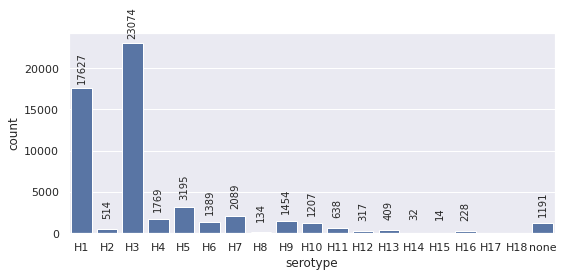

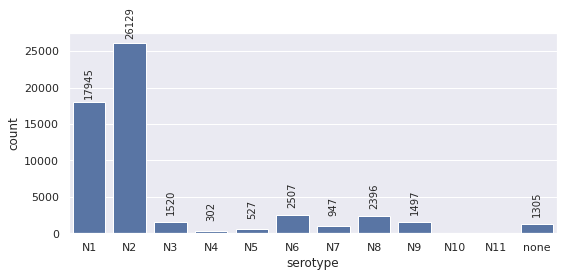

In [27]:
plot_serotypes(upload, outfolder, 4, Hs, 'H')
plot_serotypes(upload, outfolder, 6, Ns, 'N')

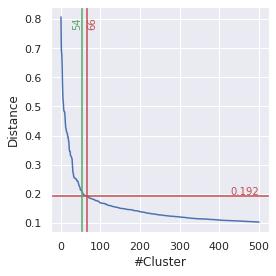

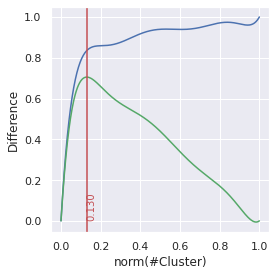

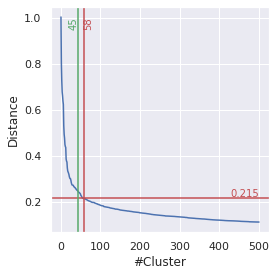

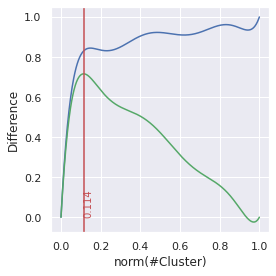

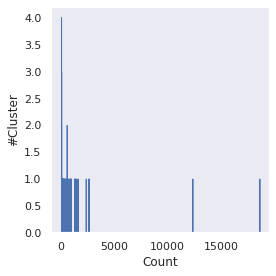

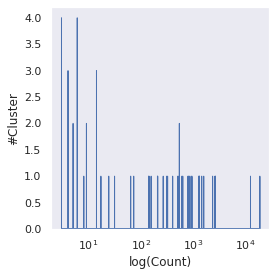

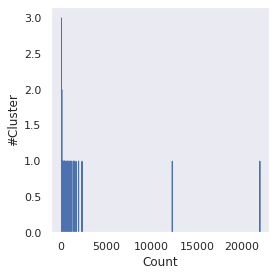

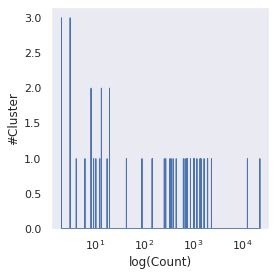

In [28]:
#display(cluster)
plot_elbow(elbow, information, segments, outfolder)
plot_density(density, segments, outfolder, 1)

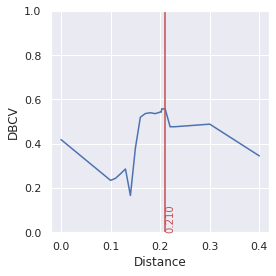

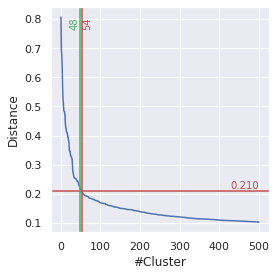

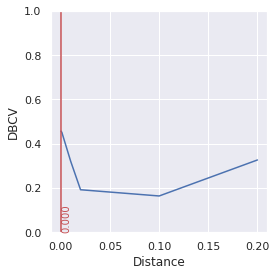

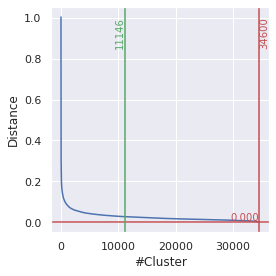

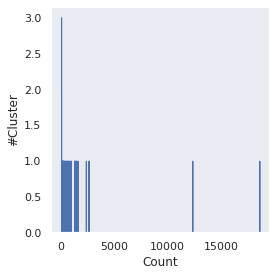

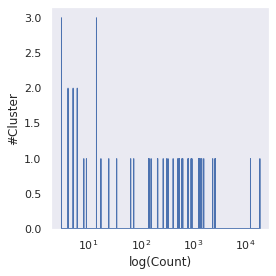

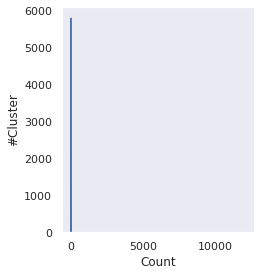

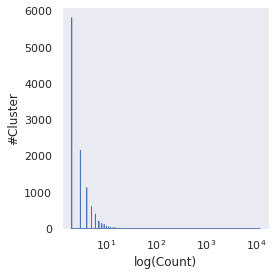

In [39]:
#display(cluster_alt)
plot_dbcv(parameter, linkage, information_alt, segments, outfolder)
plot_density(density_alt, segments, outfolder, 1, '_alternative')

# L^2 Normalisation

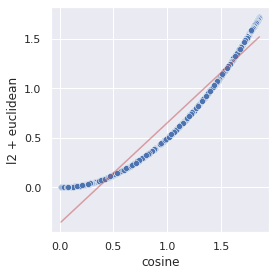

R2 Coefficient: 0.9422766133709788.


In [30]:
if metric == 'cosine':
    plot_normalization(upload, 4, 100, outfolder, 2, comp, pca)

# Clustertrees

In [31]:
tree_H_Knee, ts_H_Knee = get_tree(cluster, upload, 4, 'H', tree_hex, linkage = linkage)
_ = tree_H_Knee.render(outfolder + 'Clustertree_Segment_4_H_Knee.pdf', tree_style = ts_H_Knee)
#tree_H_Knee.render('%%inline', tree_style = ts_H_Knee)

In [32]:
#tree_H_DBCV, ts_H_DBCV = get_tree(cluster_alt, upload, 4, 'H', tree_hex, linkage = linkage)
#_ = tree_H_DBCV.render(outfolder + 'Clustertree_H_DBCV.pdf', tree_style = ts_H_DBCV)
#tree_H_DBCV.render('%%inline', tree_style = ts_H_DBCV)

In [33]:
tree_N_Knee, ts_N_Knee = get_tree(cluster, upload, 6, 'N', tree_hex, linkage = linkage)
_ = tree_N_Knee.render(outfolder + 'Clustertree_Segment_6_N_Knee.pdf', tree_style = ts_N_Knee)
#tree_N_Knee.render('%%inline', tree_style = ts_N_Knee)

In [34]:
#tree_N_DBCV, ts_N_DBCV = get_tree(cluster_alt, upload, 6, 'N', tree_hex, linkage = linkage)
#_ = tree_N_DBCV.render(outfolder + 'Clustertree_N_DBCV.pdf', tree_style = ts_N_DBCV)
#tree_N_DBCV.render('%%inline', tree_style = ts_N_DBCV)

# MSA Guidetrees

In [35]:
sequences_H_MSA = cluster.query('segment == 4 & centroid == True')    
fasta_H_MSA = sequences_H_MSA.join(genome)[['genome']]

alignment_H_MSA = alignment(fasta_H_MSA, 6, outfolder + 'guidetree_segment_4_H_centroid.fasta', outfolder + 'guidetree_segment_4_H_centroid.msa', True)

tree_H_MSA, ts_H_MSA = get_tree(cluster, upload, 4, 'H', tree_hex, collapse = False, path_phylo = outfolder + 'guidetree_segment_4_H_centroid.fasta.tree')
_ = tree_H_MSA.render(outfolder + 'Guidetree_segment_4_H_Centroid.pdf', tree_style = ts_H_MSA)
#tree_H_MSA.render('%%inline', tree_style = ts_H_MSA)

In [36]:
sequences_N_MSA = cluster.query('segment == 6 & centroid == True')    
fasta_N_MSA = sequences_N_MSA.join(genome)[['genome']]

alignment_N_MSA = alignment(fasta_N_MSA, 6, outfolder + 'guidetree_segment_6_N_centroid.fasta', outfolder + 'guidetree_segment_6_N_centroid.msa', True)

tree_N_MSA, ts_N_MSA = get_tree(cluster, upload, 6, 'N', tree_hex, collapse = False, path_phylo = outfolder + 'guidetree_segment_6_N_centroid.fasta.tree')
_ = tree_N_MSA.render(outfolder + 'Guidetree_Segment_6_N_Centroid.pdf', tree_style = ts_N_MSA)
#tree_N_MSA.render('%%inline', tree_style = ts_N_MSA)

# Mixed Clusters

In [37]:
for seg, prot in zip([4, 6], ['H', 'N']):
    for group in cluster.query('segment == @seg & cluster != -1').groupby('cluster').filter(lambda x: x[prot].replace('', np.nan).nunique() > 1).groupby('cluster'):
        number = group[0]
        subtype = group[1][prot].mode()[0]
        distance, difference = check_error(cluster, number, subtype, seg, outfolder, 5)
        #display(difference)

# Centroid based Comparisons (need manual adjustment)

In [38]:
#investigation parameter
inv_sub = ['H13', 'H16']
inv_prot = 'H'
inv_seg = 4
inv_name = str(inv_seg) + '_' + inv_prot + '_'

## Clustertree to Alignment

In [39]:
list_cluster = list(set(cluster.query('segment == @inv_seg & H in @inv_sub | segment == @inv_seg & N in @inv_sub')['cluster'].tolist()))

In [40]:
list_prune = list(map(str,list_cluster))

sequences_comp = cluster.query('segment == @inv_seg & cluster in @list_cluster & centroid == True')  
fasta_comp = sequences_comp.join(genome).reset_index().set_index('cluster')[['genome']]

alignment_comp = alignment(fasta_comp.rename('>{}'.format), 6, outfolder + 'clustertree_segment_' + inv_name + 'comparison.fasta', outfolder + 'clustertree_segment_' + inv_name + 'comparison.msa', True)
dictionary_comp = dict_alignment(alignment_comp, reduce = True, treshold = 1)

tree_comp, ts_comp = get_tree(cluster, upload, inv_seg, inv_prot, tree_hex, list_prune = list_prune, linkage = linkage, msa_dict = dictionary_comp)
_ = tree_comp.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Comparison.pdf', tree_style = ts_comp)
#tree_comp.render('%%inline', tree_style = ts_comp)

## Supercluster

In [41]:
dataframe_info, dist_evol_normalized, dist_evol_super_normalized, dist_kmer_normalized, dist_kmer_super_normalized, dist_clust_normalized, dist_clust_super_normalized = compare_dist(cluster, genome, inv_seg, inv_prot, tree_H_Knee, tree_hex, metric, Hs, list_cluster = list_cluster, list_subtype = [])    

#display(dist_clust_normalized)
#display(dist_clust_super_normalized)
#display(dist_evol_normalized)
#display(dist_evol_super_normalized)
#display(dist_kmer_normalized)
#display(dist_kmer_super_normalized)

# All Sequence based Comparisons (need manual adjustment)

## The Clustertree 

In [42]:
tree_zoom_Knee, ts_zoom_Knee = get_tree(cluster, upload, inv_seg, inv_prot, tree_hex, linkage = linkage, list_focus = list_cluster)
_ = tree_zoom_Knee.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Knee_Zoom.pdf', tree_style = ts_zoom_Knee)
#tree_zoom_Knee.render('%%inline', tree_style = ts_zoom_Knee)

## Reclustering with Precalculated and the Dataframe

### Alignment

In [43]:
sequences_focus = cluster.query('segment == @inv_seg & cluster in @list_cluster')  
fasta_focus = sequences_focus.join(genome)[['genome']]

alignment_focus = alignment(fasta_focus, 6, outfolder + 'guidetree_segment_' + inv_name + 'focus.fasta', outfolder + 'guidetree_segment_' + inv_name + 'focus.msa', True)

calculator_focus = DistanceCalculator('identity')
dist_focus = np.matrix(calculator_focus.get_distance(AlignIO.read(open(outfolder + 'guidetree_segment_' + inv_name + 'focus.msa'), 'fasta')))

In [44]:
clusterer_focus = hdbscan.HDBSCAN(
    min_samples = sample,
    min_cluster_size = 5,
    cluster_selection_epsilon = 0.0,
    gen_min_span_tree=True,
    metric = 'precomputed',
    algorithm = algo,
).fit(dist_focus)

cluster_focus = sequences_focus.drop(['cluster', 'centroid'], axis = 1)
cluster_focus['cluster'] = clusterer_focus.labels_
linkage_focus = clusterer_focus.single_linkage_tree_.to_pandas()
linkage_focus['segment'] = inv_seg

tree_focus_cluster, ts_focus_cluster = get_tree(cluster_focus, upload, inv_seg, inv_prot, tree_hex, linkage = linkage_focus)
_ = tree_focus_cluster.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Focus.pdf', tree_style = ts_focus_cluster)
#tree_focus_cluster.render('%%inline', tree_style = ts_focus_cluster)

In [45]:
tree_focus, ts_focus = get_tree(cluster, upload, inv_seg, inv_prot, tree_hex, collapse = False, path_phylo = outfolder + 'guidetree_segment_' + inv_name + 'focus.fasta.tree')
_ = tree_focus.render(outfolder + 'Guidetree_Segment_' + inv_name + 'Focus.pdf', tree_style = ts_focus)
#tree_focus.render('%%inline', tree_style = ts_focus)

### Clustertree

In [46]:
fasta_index = fasta_focus.index.values.tolist()
fasta_accession = pd.DataFrame(fasta_index, columns = ['accession'])
fasta_sequence = fasta_focus.reset_index(drop = True)

In [47]:
dataframe_simple, _ = get_vectors(fasta_sequence, fasta_accession, metric, neigh, comp, pca)

In [48]:
clusterer_simple = hdbscan.HDBSCAN(
    min_samples = sample,
    min_cluster_size = 5,
    cluster_selection_epsilon = 0.0,
    gen_min_span_tree=True,
    algorithm = algo,
).fit(dataframe_simple)

cluster_simple = sequences_focus.drop(['cluster', 'centroid'], axis = 1)
cluster_simple['cluster'] = clusterer_simple.labels_
linkage_simple = clusterer_simple.single_linkage_tree_.to_pandas()
linkage_simple['segment'] = inv_seg

tree_simple_cluster, ts_simple_cluster = get_tree(cluster_simple, upload, inv_seg, inv_prot, tree_hex, linkage = linkage_simple)
_ = tree_simple_cluster.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Simple.pdf', tree_style = ts_simple_cluster)
#tree_simple_cluster.render('%%inline', tree_style = ts_simple_cluster)

In [49]:
tree_zoom_simple, ts_zoom_simple = get_tree(cluster_simple, upload, inv_seg, inv_prot, tree_hex, linkage = linkage_simple, collapse = False)
_ = tree_zoom_simple.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Simple_Zoom.pdf', tree_style = ts_zoom_simple)
#tree_zoom_simple.render('%%inline', tree_style = ts_zoom_simple)

### Precalculated Cosine

In [50]:
freq = frequency(k = 7, convert = 0)
freq.adjust_to_data(fasta_sequence)
freq.calculate_frequence(fasta_sequence)

fasta_matrix = freq.get_matrix()
dist_cos = ssd.cdist(fasta_matrix, fasta_matrix, metric = 'cosine')
matrix_cos = DistanceMatrix(names=fasta_index, matrix=[j[:i].tolist() for i, j in enumerate(dist_cos, 1)])

In [51]:
clusterer_cos = hdbscan.HDBSCAN(
    min_samples = sample,
    min_cluster_size = 5,
    cluster_selection_epsilon = 0.0,
    gen_min_span_tree=True,
    metric = 'precomputed',
    algorithm = algo,
).fit(dist_cos)

cluster_cos = sequences_focus.drop(['cluster', 'centroid'], axis = 1)
cluster_cos['cluster'] = clusterer_cos.labels_
linkage_cos = clusterer_cos.single_linkage_tree_.to_pandas()
linkage_cos['segment'] = inv_seg

tree_cos_cluster, ts_cos_cluster = get_tree(cluster_cos, upload, inv_seg, inv_prot, tree_hex, linkage = linkage_cos)
_ = tree_cos_cluster.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Cosine.pdf', tree_style = ts_cos_cluster)
#tree_cos_cluster.render('%%inline', tree_style = ts_cos_cluster)

In [52]:
constructor = DistanceTreeConstructor()
phylo_cos = constructor.upgma(matrix_cos)

_ = Phylo.write(phylo_cos, outfolder + 'precalculated_segment_' + inv_name + 'cosine.tree', 'newick')

for line in fileinput.input(outfolder + 'precalculated_segment_' + inv_name + 'cosine.tree', inplace=True):
    print(re.sub(r'Inner(\d+):', ':', re.sub(r'>', '_', line)))

tree_cos, ts_cos = get_tree(cluster, upload, inv_seg, inv_prot, tree_hex, collapse = False, path_phylo = outfolder + 'precalculated_segment_' + inv_name + 'cosine.tree')
_ = tree_cos.render(outfolder + 'Precalculated_Segment_' + inv_name + 'Cosine.pdf', tree_style = ts_cos)
#tree_cos.render('%%inline', tree_style = ts_cos)

### Precalculated Euclidean

In [53]:
dist_eucl = ssd.cdist(fasta_matrix, fasta_matrix, metric = 'euclidean')
matrix_eucl = DistanceMatrix(names=fasta_index, matrix=[j[:i].tolist() for i, j in enumerate(dist_eucl, 1)])

In [54]:
clusterer_eucl = hdbscan.HDBSCAN(
    min_samples = sample,
    min_cluster_size = 5,
    cluster_selection_epsilon = 0.0,
    gen_min_span_tree=True,
    metric = 'precomputed',
    algorithm = algo,
).fit(dist_eucl)

cluster_eucl = sequences_focus.drop(['cluster', 'centroid'], axis = 1)
cluster_eucl['cluster'] = clusterer_eucl.labels_
linkage_eucl = clusterer_eucl.single_linkage_tree_.to_pandas()
linkage_eucl['segment'] = inv_seg

tree_eucl_cluster, ts_eucl_cluster = get_tree(cluster_eucl, upload, inv_seg, inv_prot, tree_hex, linkage = linkage_eucl)
_ = tree_eucl_cluster.render(outfolder + 'Clustertree_Segment_' + inv_name + 'Euclidean.pdf', tree_style = ts_eucl_cluster)
#tree_eucl_cluster.render('%%inline', tree_style = ts_eucl_cluster)

In [55]:
constructor = DistanceTreeConstructor()
phylo_eucl = constructor.upgma(matrix_eucl)

_ = Phylo.write(phylo_eucl, outfolder + 'precalculated_segment_' + inv_name + 'euclidean.tree', 'newick')

for line in fileinput.input(outfolder + 'precalculated_segment_' + inv_name + 'euclidean.tree', inplace=True):
    print(re.sub(r'Inner(\d+):', ':', re.sub(r'>', '_', line)))

tree_eucl, ts_eucl = get_tree(cluster, upload, inv_seg, inv_prot, tree_hex, collapse = False, path_phylo = outfolder + 'precalculated_segment_' + inv_name + 'euclidean.tree')
_ = tree_eucl.render(outfolder + 'Precalculated_Segment_' + inv_name + 'Euclidean.pdf', tree_style = ts_eucl)
#tree_eucl.render('%%inline', tree_style = ts_eucl)

# Final Method Comparison

## PCA and Neighbors

[elapsed time: 0:04:07] |###################################| (Time:  0:04:07) 


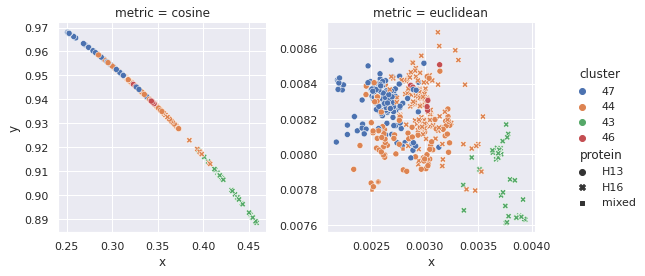

In [56]:
dataframe_comp = compare_2D(cluster, upload, pca, comp, inv_seg, inv_prot, list_cluster)

## Distance of similar Sequences

In [57]:
sequence_dupl = upload.query('segment in @segments').reset_index().pivot_table(index = ['genome'], aggfunc ='size').idxmax()

list_dupl = upload.query('genome == @sequence_dupl')['accession'].tolist()

dist_dupl = ssd.cdist(dataframe.loc[list_dupl], dataframe.loc[list_dupl], metric = 'euclidean')

matrix_dupl = DistanceMatrix(names = list_dupl, matrix=[j[:i].tolist() for i, j in enumerate(dist_dupl, 1)])

dataframe_dupl = pd.DataFrame(np.matrix(matrix_dupl), index = list_dupl, columns = list_dupl)

In [58]:
dataframe_dupl.to_csv(outfolder + 'dataframe_duplicates.csv', index=True, header=True, sep=',', mode='w')

In [59]:
display(dataframe_dupl)

,>KX409709,>KX406021,>KY044964,>KX005972,>KX915606,...,>KX005316,>KX406997,>KX410141,>KX410917,>KX915686
>KX409709,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX406021,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KY044964,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX005972,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX915606,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX918446,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX006036,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX406413,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX406445,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
>KX004717,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
